In [369]:
# Standard Dependencies
import cv2
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow Dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [370]:
# End Result
# Model(input = [inputImage,verificationImage] , output = [0,1])

In [371]:
# Set GPU Growth ( For GPU Based Machines )

# Avoid OOM errors by setting the GPU Memory consuption growth

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [372]:
len(gpus)  # this 0 zero length is saying that My machine doesn't have any GPu

0

In [373]:
# To create Folder Using OS

POS_PATH = os.path.join("data", "postive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [374]:
# Uncompress Tar GZ Labelled Faces
# !tar -xf lfw.tgz

In [375]:
# Move LFW Images to the Negative Repository (data/negative).

# for directory in os.listdir("lfw"):
#     for file in os.listdir(os.path.join("lfw", directory)):
#         EX_PATH = os.path.join("lfw", directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [376]:
# For generating Unique Id for the Image
import uuid

In [377]:
# Establish a Connection to the WebCam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120 : 120 + 250, 160 : 160 + 250, :]

    cv2.imshow("Image Collection", frame)

    # Anchor Collection
    if cv2.waitKey(1) & 0xFF == ord("a"):
        # Create a unique Image name
        imagName = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))

        # Save the Image
        cv2.imwrite(imagName, frame)

    # Positive Collection
    if cv2.waitKey(1) & 0xFF == ord("p"):
        # Create a unique Image name
        imagName = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))

        # Save the Image
        cv2.imwrite(imagName, frame)

    # Show image back to the Screen
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the WebCam
cap.release()
# Close the Image show Frame
cv2.destroyAllWindows()

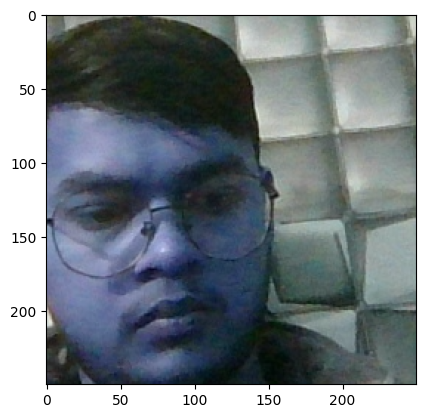

In [378]:
plt.imshow(frame)

In [379]:
# plt.imshow(frame[120 : 120 + 250, 160 : 160 + 250, :])

In [380]:
# Get Image Directories

anchor = tf.data.Dataset.list_files(ANC_PATH + "\\*.jpg").take(300)
postive = tf.data.Dataset.list_files(POS_PATH + "\\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "\\*.jpg").take(300)

In [381]:
dir_test = anchor.as_numpy_iterator()

In [382]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [383]:
anchor.map(preprocess)

<_MapDataset element_spec=TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)>

In [384]:
# Labelled Dataset

# (anchor , positive) => 1,1,1,1,1,1,.....
# (anchor , negative) => 0,0,0,0,0,0,.....

In [385]:
positives = tf.data.Dataset.zip(
    (anchor, postive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
)
negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
)

In [386]:
data = positives.concatenate(negatives)

In [387]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [388]:
samples = data.as_numpy_iterator()

In [389]:
samples.next()

(b'data\\anchor\\8b19d8ed-cab2-11ef-af06-bce92feafdf8.jpg',
 b'data\\postive\\8a003b36-cb2c-11ef-a7e0-bce92feafdf8.jpg',
 1.0)

In [390]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [391]:
# Building Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [393]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [394]:
# Testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))